# Задание №2. Метод ломаных

**Ф.И.О.:** Филиппов Владимир Леонидович    
**Поток:** МетОпт 1.2  

## Что делает программа
1) Принимает липшицеву функцию `f(x)` как строку.
2) Принимает отрезок `[a,b]` и точность `eps`.
3) Ищет **глобальный минимум** на отрезке методом Пиявского (метод ломаных).
4) Выводит `x*`, `f(x*)`, число итераций и время.
5) Рисует график функции + ломаную (нижнюю оценку) + пробные точки.
6) Может сохранить график в **PDF** для сдачи.

## 1) Импорт библиотек (минимум)
Используем только `math`, `time`, `numpy`, `matplotlib`.

In [2]:
import math
import time
import numpy as np
import matplotlib.pyplot as plt


## 2) Класс `PiyavskyMethod`
Внутри класса:
- из строки `func` строится реальная функция `self.func(x)`;
- хранятся уже посчитанные точки `(x, f(x))`;
- `step()` делает 1 шаг метода;
- `solve()` повторяет шаги до достижения точности `eps`;
- `plot()` рисует функцию, ломаную и точки (и может сохранять PDF).


In [1]:
class PiyavskyMethod:
    """
    Класс для нахождения минимума липшицевой функции с помощью метода Пиявского (ломанных).
    """
    def __init__(self, func: str, x_start: float, x_end: float, eps=0.01) -> None:
        """
        Метод для инициализации класса. Принимает условия задачи и осуществляет первичную обработку.
        Аргументы:
            func: Строка с липшицевой функцией (например, "f(x)=x+sin(3.14159*x)").
            x_start: Координата X начала рассматриваемого отрезка.
            x_end: Координата X конца рассматриваемого отрезка.
            eps: Точность вычислений (например, 0.01).
        """
        # Сохраняем заданные параметры на уровне класса
        self.func_str = func
        self.x_start = x_start
        self.x_end = x_end
        self.eps = eps
        
        # Получаем программное представление заданной функции
        # (чтобы можно было находить значения функции при различных X)
        self.func = self._create_func()
        
        # Рассчитываем и получаем значение константы Липшица
        self.L = self._get_L()
        
        # В качестве двух начальных точек берём точки границ отрезка 
        self.points = [
            (self.x_start, self.func(self.x_start)),
            (self.x_end, self.func(self.x_end))
        ]
        
        # Словарь для хранения кэша с точками пересечения
        # (чтобы не рассчитывать их повторно)
        self.intersect_cache = {}
        
        # Число итераций для достижения решения с заданной точностью.
        # Данное значение доступно лишь после полного решения задачи (до этого равно None)
        self.iteration_count = 0

    def step(self) -> bool:
        """
        Делает один шаг по методу Пиявского.
        Returns:
            True если достигнута заданная точность, False если ещё нет.
        """
        # Увеличиваем счётчик итераций
        self.iteration_count += 1
        
        # Находим следующую точку для исследования
        x_new, lower_bound = self._find_next_point()
        
        # Вычисляем реальное значение функции
        f_new = self.func(x_new)
        
        # Добавляем новую точку
        self.points.append((x_new, f_new))
        
        # Сортируем список точек по X
        self.points.sort(key=lambda p: p[0])
        
        # Находим текущий зазор
        current_best_f = min(p[1] for p in self.points)
        gap = current_best_f - lower_bound
        
        # Если зазор меньше заданной точности, то возвращаем True, если больше - False
        return gap < self.eps

    def plot(self, show_solution=True, save_path=None, show=True) -> None:
        """
        Визуализирует текущее состояние решения: функцию, вычисленные точки и ломаную.
        Если `show_solution=False`, то визуализируется только график заданной функции.
        """
        # Создаём точки для гладкого отображения функции
        x_smooth = np.linspace(self.x_start, self.x_end, 1000)
        y_smooth = [self.func(x) for x in x_smooth]
        
        # Если стоим не только функцию
        if show_solution:
            # Разделяем сохранённые точки на X и Y
            x_points = [p[0] for p in self.points]
            y_points = [p[1] for p in self.points]
            
            # Списки для координат, задающих ломаную (нижнюю огибающую)
            x_polyline = []
            y_polyline = []
            
            # Перебираем все интервалы
            for i in range(len(self.points) - 1):
                x1, f1 = self.points[i]
                x2, f2 = self.points[i + 1]
                
                # Добавляем левую точку "зубца"
                x_polyline.append(x1)
                y_polyline.append(f1)
                
                # Добавляем точку пересечения (вершину "зубца")
                x_intersect, y_intersect = self._get_intersect_coord(x1, f1, x2, f2)
                x_polyline.append(x_intersect)
                y_polyline.append(y_intersect)
            
            # Добавляем последнюю точку
            x_polyline.append(self.points[-1][0])
            y_polyline.append(self.points[-1][1])
        
        # Создаём график
        plt.figure(figsize=(12, 7))
        
        # График исходной функции
        plt.plot(x_smooth, y_smooth, 'b-', linewidth=2, zorder=5, label='Функция f(x)')
        
        if show_solution:
            # Ломаная Пиявского
            plt.plot(x_polyline, y_polyline, 'r-', linewidth=1, zorder=10, label='Ломаная (нижняя оценка)')
            
            # Вычисленные точки
            plt.scatter(x_points, y_points, color='red', s=20, zorder=15, label='Вычисленные точки')
            
            # Лучшая точка (минимальная)
            best_point = min(self.points, key=lambda p: p[1])
            plt.scatter([best_point[0]], [best_point[1]], color='green', s=100, zorder=15,
                        label=f'Минимальная точка: f({best_point[0]:.3f}) = {best_point[1]:.3f}')
        
        # Настройки графика
        plt.xlabel('x', fontsize=12, fontweight='bold')
        plt.ylabel('f(x)', fontsize=12, fontweight='bold')
        if show_solution:
            plt.title(f'Метод Пиявского - График текущего состояния (итерация #{self.iteration_count})',
                    fontsize=14, fontweight='bold')
        else:
            plt.title('График заданной функции', fontsize=14, fontweight='bold')
        
        plt.grid(True, alpha=0.2, linestyle='-', color='gray')
        # Выделяем оси X и Y, но так, чтобы они не смещали форматирование графика
        x_limits = plt.xlim()
        y_limits = plt.ylim()
        if x_limits[0] <= 0 <= x_limits[1]:
            plt.axvline(x=0, color='black', linewidth=2, alpha=0.7, linestyle='-')
        if y_limits[0] <= 0 <= y_limits[1]:
            plt.axhline(y=0, color='black', linewidth=2, alpha=0.7, linestyle='-')
        plt.xlim(x_limits)
        plt.ylim(y_limits)
        plt.legend()
        
        # Отображаем график
        plt.tight_layout()

        # Сохранение графика в файл
        if save_path is not None:
            plt.savefig(save_path, bbox_inches='tight', facecolor='white')

        # Показать или закрыть график
        if show:
            plt.show()
        else:
            plt.close()

    def solve(self, max_iterations=10000) -> tuple[float, float]:
        """
        Метод для решения задачи нахождения минимума функции с помощью метода Пиявского.
        Возвращает координаты найденной минимальной точки: (x_min, f(x_min)).
        Аргументы:
            max_iterations: Максимальное число итераций (защита от бесконечного цикла).
        """
        # Делаем шаги по методу Пиявского, пока не будет достигнута заданная точность
        # или превышено максимальное число итераций
        for _ in range(max_iterations):
            is_sufficient_accuracy = self.step()
            if is_sufficient_accuracy:
                break
        
        # Находим и возвращаем минимальную точку
        min_point = min(self.points, key=lambda p: p[1])
        return min_point

    def solve_for_iterations(self, target_iterations: int) -> tuple[float, float]:
        """
        Выполняет заданное количество итераций метода Пиявского.
        Возвращает координаты найденной минимальной точки: (x_min, f(x_min)).
        Аргументы:
            target_iterations: Целевое количество итераций для выполнения.
        """
        # Выполняем заданное количество итераций
        for _ in range(target_iterations):
            self.step()
        
        # Находим и возвращаем минимальную точку
        min_point = min(self.points, key=lambda p: p[1])
        return min_point

    def _find_next_point(self) -> tuple[float, float]:
        """
        Находит следующую точку для исследования и значение нижней оценки.
        
        Returns:
            (x_new, lower_bound) - координата X новой точки и значение ломаной в ней
        """
        best_x = None
        best_lower_bound = float('inf')
        # Начало и конец интервала, содержащего лучшую точку
        # (используется для удаления лишнего кэша)
        best_interval_x1 = None
        best_interval_x2 = None
        
        # Проверяем все интервалы между соседними точками
        for i in range(len(self.points) - 1):
            x1, f1 = self.points[i]
            x2, f2 = self.points[i + 1]
            
            # Вычисляем координаты точки пересечения
            x_intersect, y_intersect = self._get_intersect_coord(x1, f1, x2, f2)
            
            # При необходимости кэшируем координаты точки пересечения
            if (x1, x2) not in self.intersect_cache:
                self.intersect_cache[(x1, x2)] = (x_intersect, y_intersect)
            
            # При необходимости обновляем лучшие значения
            if y_intersect < best_lower_bound:
                best_lower_bound = y_intersect
                best_x = x_intersect
                best_interval_x1 = x1
                best_interval_x2 = x2
        
        # Так как этот интервал будет разделён, то удаляем его из кэша
        del self.intersect_cache[(best_interval_x1, best_interval_x2)]
        
        # Возвращаем полученные значения
        return best_x, best_lower_bound

    def _get_intersect_coord(self, x1: float, f1: float, x2: float, f2: float) -> tuple[float, float]:
        """
        Возвращает точку пересечения двух прямых с наклоном -L и L для двух заданных точек.
        При возможности использует кэш для избежания лишних вычислений, но сам значения не кэширует.
        Для корректной работы требуется, чтобы первая точка была правее второй.
        """
        if (x1, x2) in self.intersect_cache:
            return self.intersect_cache[(x1, x2)]
        
        x_intersect = ((f1 - f2) / (2 * self.L)) + ((x1 + x2) / 2)
        y_intersect = f1 - self.L * (x_intersect - x1)
        return x_intersect, y_intersect
    
    def _create_func(self):
        """
        Метод для получения программного представления заданной функции.
        """
        # Преобразуем строку с функцией к читаемому для eval формату
        func_expr = self.func_str.strip()
        func_expr = func_expr.replace("f(x)=", "")
        
        # Возвращаем лямбда-функцию
        return lambda x: eval(func_expr, {"math": math, "x": x})

    def _get_L(self) -> float:
        """
        Метод для расчёта приблизительного значения константы Липшица L.
        """
        # Разбиваем отрезок на равномерно распределённые точки
        n_points = 1000
        x_samples = np.linspace(self.x_start, self.x_end, n_points)
        
        # Начальное значение максимальной производной
        max_deriv = 0
        
        # Рассчитываем шаг для расчёта производных
        h = x_samples[1] - x_samples[0]
        
        # Перебираем все точки
        for x in x_samples:
            # Проверяем, что мы не выходим за пределы заданного диапазона
            if x - h >= self.x_start and x + h <= self.x_end:
                # Рассчитываем производную для рассматриваемого X
                derivative = (self.func(x + h) - self.func(x - h)) / (2 * h)
                
                # При необходимости обновляем максимальное значение производной
                max_deriv = max(max_deriv, abs(derivative))
        
        # Возвращаем максимальное значение производной с небольшим запасом
        # (для большей надёжности)
        return max_deriv * 1.2


## 3) Тестовые функции
В ноутбуке есть набор тестов.
- **Растригин** (`test_6`)
- **Экли** (`test_7`)


In [3]:
# Определение тестовых случаев
test_1 = ("f(x)=2*x+math.cos(math.pi*x)+math.sin(math.pi*x)", -2, 1, 0.01)

test_2 = ("f(x)=-197*math.sin(math.sqrt(abs(x/2+197)))-x*math.sin(math.sqrt(abs(x-197)))", -360, 180, 0.01)

test_3 = ("f(x)=math.sqrt(x)*math.sin(x)", 1, 8, 0.01)

test_4 = ("f(x)=math.sqrt(1+3*math.cos(x)**2)+math.cos(10*x)", 1, 5, 0.01)

test_5 = ("f(x)=100+math.cos(10*x)", 1, 3, 0.01)

# Функция Растригина
test_6 = ("f(x)=10+x**2-10*math.cos(2*math.pi*x)", -3, 3, 0.01)

# Функция Экли
test_7 = ("f(x)=-20*math.exp(-0.2*math.sqrt(x**2))-math.exp(math.cos(2*math.pi*x))+20+math.exp(1)", -3, 3, 0.01)

test_8 = ("f(x)=abs(math.sin(x))+0.5*abs(math.cos(5*x))", -2.5, 2.5, 0.01)

test_9 = ("f(x)=math.sin(x) + 0.3*math.sin(10*x) + 0.1*math.sin(50*x) + 0.01*x**2", -5, 5, 0.01)

test_10 = ("f(x)=math.tanh(10*(x-1))-math.tanh(10*(x+1))+0.5*math.sin(5*x)", -3, 3, 0.01)

test_11 = ("f(x)=0.5*(math.sin(20*x)/(20*x)+1)+0.2*math.sin(x)+0.1*x", 0.1, 4, 0.01)

test_12 = ("f(x)=math.sin(5*x)*math.exp(-abs(x))+0.3*math.cos(15*x)*math.exp(-0.5*abs(x-2))+0.05*x", -3, 5, 0.01)


In [4]:
def main(test, target_iterations=None, save_path=None, show_plot=True):
    """
    Запускает метод Пиявского для заданного теста.
    Аргументы:
        test: Кортеж с параметрами теста (func, x_start, x_end, eps)
        target_iterations: Если указано, выполняется заданное количество итераций.
                          Если None, выполняется до достижения точности.
    """
    func = test[0]
    x_start = test[1]
    x_end = test[2]
    eps = test[3]
    
    # Создание экземпляра класса (время на вычисление константы Липшица)
    start_time = time.time()
    pm = PiyavskyMethod(func, x_start, x_end, eps)
    init_time = time.time() - start_time
    
    # Выполнение алгоритма
    start_time = time.time()
    if target_iterations is not None:
        x_min, f_min = pm.solve_for_iterations(target_iterations)
        solve_time = time.time() - start_time
        print(f"Найденный минимум: f({x_min})={f_min}")
        print(f"Число итераций: {target_iterations}")
    else:
        x_min, f_min = pm.solve()
        solve_time = time.time() - start_time
        print(f"Найденный минимум: f({x_min})={f_min}")
        print(f"Число итераций: {pm.iteration_count}")
    
    total_time = init_time + solve_time
    print(f"Время инициализации: {init_time:.4f} секунд")
    print(f"Время решения: {solve_time:.4f} секунд")
    print(f"Общее время: {total_time:.4f} секунд")
    
    pm.plot(save_path=save_path, show=show_plot)


## 4) Запуск и сохранение PDF

Ниже запускаем **Растригина** (имеет много локальных минимумов) и сохраняем график в PDF.
Если нужно — можно заменить `test_6` на `test_7` (Экли).


Найденный минимум: f(0.0)=0.0
Число итераций: 176
Время инициализации: 0.0298 секунд
Время решения: 0.0130 секунд
Общее время: 0.0428 секунд


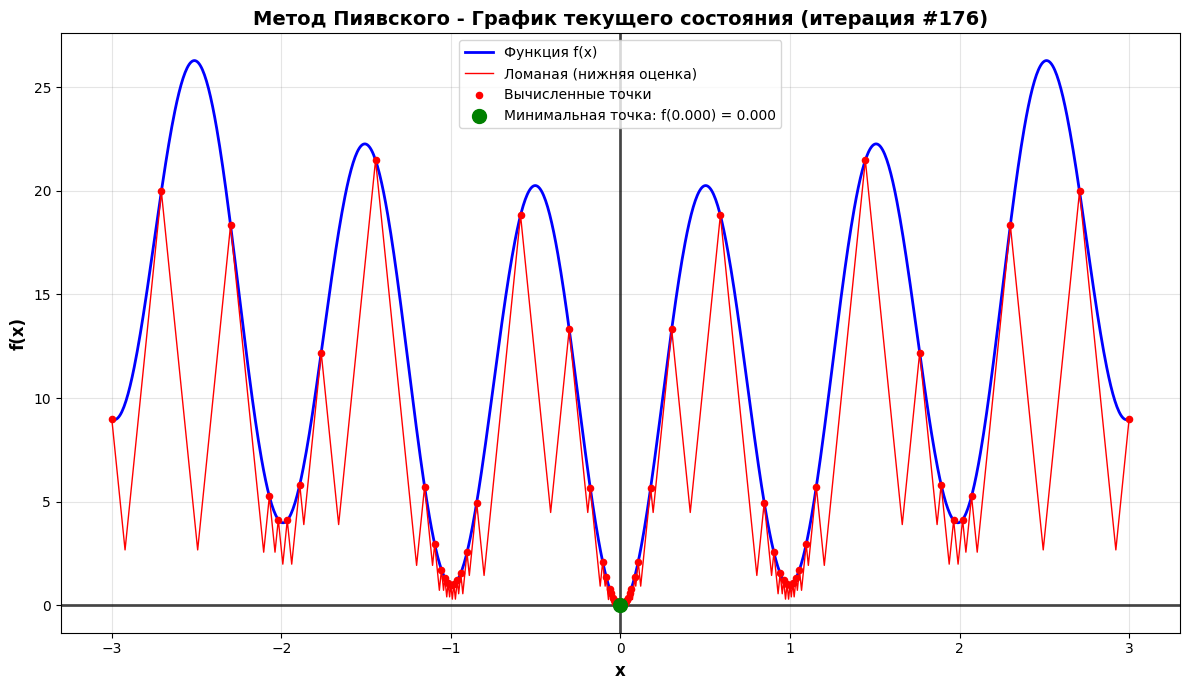

PDF сохранён: lab2_demo.pdf


In [5]:
# Демонстрация: Растригин
# Сохраняем результат в PDF
main(test_6, save_path="lab2_demo.pdf", show_plot=True)

print("PDF сохранён: lab2_demo.pdf")
